In [1]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import camb

In [386]:
pars = camb.CAMBparams()
def get_spectra(H0=67, Ombh2=0.024, Omch2=0.12,
                tau=0.054, As=2.1e-9, ns=0.965,
                ks=0.05, kt=0.05,
                Omk=0, TCMB=2.7255, mnu=0.06,
                r=0, YHe=0.245400,
                lmax=2500, unit='muK', raw_cl=True):
    '''
    The cosmological parameter assumed here are from the abstract of the Planck 2018 results paper
    https://arxiv.org/abs/1807.06209.
    '''
    pars.set_cosmology(H0=H0, ombh2=Ombh2, omch2=Omch2, mnu=mnu, omk=Omk, tau=tau, TCMB=TCMB, YHe=YHe)
    pars.InitPower.set_params(As=As, ns=ns, r=r, pivot_scalar=ks, pivot_tensor=kt)
    pars.set_for_lmax(lmax)
    result = camb.get_results(pars)
    powers = result.get_total_cls(lmax=lmax, CMB_unit=unit, raw_cl=raw_cl)
    TT, EE, BB, TE = powers.T
    return np.array([TT, EE, BB, TE])

def smooth(map_in, input_res=np.nan, output_res_i=60, output_res_qu=None, beam=None):
    '''
    input_res: fwhm of input map, in arcmin.
    output_res: desired fwhm, in arcmin.
    '''
    print('Smoothing map...')
    out_i = output_res_i
    out_qu = output_res_qu
    nside = hp.get_nside(map_in)
    verbose=True
    #If no qu resolution specified, assume same for all:
    if output_res_qu == None:
        output_res_qu = output_res_i
    input_res = input_res * np.pi/180/60
    output_res_i= output_res_i * np.pi/180/60
    output_res_qu = output_res_qu * np.pi/180/60
    map_out = np.array(map_in)
    fwhm_i = np.sqrt(output_res_i**2-input_res**2)
    fwhm_qu = np.sqrt(output_res_qu**2 - input_res**2)
    if beam is None: 
        print('Smoothing I to {} arcmin...'.format(out_i))
        map_out[0] = np.array(hp.sphtfunc.smoothing(map_in[0], fwhm=fwhm_i, verbose=verbose))
        print('Smoothing Q, U to {} arcmin...'.format(out_qu))
        map_out[1] = np.array(hp.sphtfunc.smoothing(map_in[1], fwhm=fwhm_qu, verbose=verbose))
        map_out[2] = np.array(hp.sphtfunc.smoothing(map_in[2], fwhm=fwhm_qu, verbose=verbose))
    if beam is not None:
        orig_bell = beam
        lmax = min(len(orig_bell)-1, 3*nside-1)
        ell = np.arange(lmax+1)
        sigma2 = output_res_i**2 / 8 / np.log(2)
        sigma2_p = output_res_qu**2 / 8 / np.log(2)
        sigmas = [sigma2, sigma2_p, sigma2_p]
        spin = [0,2,2]
        bell = np.array( [np.exp(-0.5 * (ell *(ell+1) - s**2 ) * sigmas[i]) for s, i in enumerate(spin)])
        bell /= orig_bell
    return map_out

def inpaint_pointsources(skymap, pix_index, radius=3.0):
    '''
    pix_index is pixel index to be masked and interpolated over.
    '''
    skymap = np.atleast_2d(skymap) # convert [skymap] to [[skymap]]
    cutmap = np.copy(skymap) # actual copy
    nside = hp.get_nside(skymap) 
    
    ra, dec = hp.pix2ang(nside, pix_index, lonlat=True) # get coordinate location
    theta = -dec*np.pi/180+np.pi/2 # convert to angular
    phi = ra*np.pi/180
    vec = hp.ang2vec(theta,phi)
    r = radius*np.pi/180 
    disc = hp.query_disc(nside, vec, r) # get the disk of point source
    # retrives angles for all pixels in masked disk
    angs = hp.pix2ang(nside, disc)
    angles = zip(*angs)
    vecs = []
    for ang in angles:
        vecs = np.append(vecs, hp.ang2vec(ang[0], ang[1]))
    vecs = vecs.reshape(len(disc),3)
    dist = []
    index = 0
    for v in vecs:
        dist = np.append(dist, (hp.rotator.angdist(vec,v),index))
        index += 1
    dist = dist.reshape(len(disc),2)
    # reverse sorts by the first column
    dists = dist[dist[:,0].argsort()[::-1]]
    # the inpainting algorithm starts with points furthest from 
    # the center, vec.
    # k indices I,Q,U in mmap.
    for k in cutmap: # recall the cutmap is a copy of the skymap
        k[disc]=np.NaN # disk of point source to be NaN
        while (np.isnan(k[disc])).any():
            for ii in dists:
                if np.isnan(k[disc[ii[1]]]):
                    neighbs=hp.pixelfunc.get_all_neighbours(nside,disc[ii[1]])
                    k[disc[ii[1]]]=np.nanmean(k[neighbs])
    return np.squeeze(cutmap)

def read_wmap_ptsrc_catalog(path:str):
    """
    Obtain WMAP point source coordinate
    
    Parameters:
    ==========
    path: str
        path to the point source catalog
    
    Returns:
    =========
    ptsrc: Iterable
        iterable of point source in galactic coordinate.
    """
    ptsrc = []
    with open(path, 'r') as ptsrcFile:
        for line in ptsrcFile:
            if line[0] == '#':
                continue
            else:
                entries = line.split()
                if len(entries) <= 3:
                    continue
                ptsrc.append([float(entries[2]), float(entries[3])])
    return np.array(ptsrc)

## Experimental window funciton
# B-spline function at order 3
def B3(x):
    return 1 / 12 * (np.abs(x - 2)**3 - 4 * np.abs(x - 1)**3 + 
                     6 * np.abs(x)**3 - 4 * np.abs(x + 1)**3 + np.abs(x + 2)**3)

def b(x):
    return 3 / 2 * (B3(x) - B3(2 * x))

def b_lj(l, j):
    return b(l / 2**j)

# convert cl weighting to alm weighting
def nilcWin2almWin(nilcWin, lmax:int):
    almWin = []
    for nw in nilcWin:
        tmp = np.zeros((lmax + 2) * (lmax + 1) // 2)
        for l in range(lmax + 1):
            for m in range(l + 1):
                tmp[hp.Alm.getidx(lmax, l, m)] += nw[l]
        almWin.append(tmp)
    return np.array(almWin)

def generate_window_from_def(defInfo, lmax:int):
    """
    Calculate the windows based on definition information
    
    Parameters:
    ==========
    defInfo: iterable
        iterable of length-4 vectors with first 3 entries as (lmin, lpeak, lmax), 
        last entry corresponds to nside of nilc Coefficient
    lmax: integer
        lmax of the output windows
        
    Returns:
    ==========
    Windows: iterable
        iterable of windows based on the given window definition
    """
    windows = []
    for info in defInfo:
        ell = np.arange(lmax + 1)
        h1 = np.where((info[0] <= ell) * (ell < info[1]), np.cos((info[1] - ell) * np.pi/((info[1] - info[0]) * 2)), 0)
        h2 = (ell == info[1]).astype(float)
        h3 = np.where((info[1] < ell) * (ell <= info[2]), np.cos((ell - info[1]) * np.pi/((info[2] - info[1]) * 2)), 0)
        windows.append(h1 + h2 + h3)
    windows = np.array(windows)
    return np.where(np.isnan(windows), 0, windows)

def ilc(maps, a=None, pixelWeight=None):
    """
    Perform ILC over the list of maps.
    
    Parameters:
    ==========
    maps: iterable
        iterable of maps of same component at different frequency
    a: ndarray or None
        weighting of each component at each frequency
        Default (when value is none): array of ones for obtaining CMB component
    pixelWeight: array-like
        mask applied to the ilc maps
        Default: no mask applied
        
    Returns:
    ==========
    outputMap: array-like
        single output map.
    ilcWght:
        ILC combination weighting for each component.
    """
    if a is None:
        a = np.ones(len(maps))
    if pixelWeight is None:
        pixelWeight = np.ones(len(maps[0]))
    if pixelWeight.ndim != 1:
        raise ValueError('The pixel weight / masks are expect to be 1-d (npix, ) numpy array')
    pWeight = np.transpose(np.array([[pixelWeight]]), axes=(2,0,1))
    tMaps = maps.T
    Rs = np.array([np.atleast_2d(gamma).T @ np.atleast_2d(gamma) for gamma in tMaps])
    RBar = np.sum((Rs * pWeight), axis=0) / np.sum(pixelWeight)
    ilcWght = (a.T @ np.linalg.pinv(RBar, rcond=1e-15)) / (a.T @ np.linalg.pinv(RBar, rcond=1e-15) @ a)
    outComp = ilcWght @ maps
    return outComp, ilcWght


def get_detector_beam(path: str, detector: str, detectorCount=1):
    """
    Get beam window function of WMAP for each detector
    
    Parameters:
    ==========
    path: str
        path to detector beam transfer functions of WMAP, leave detector and detector number as format field
        e.g. 'wmap_beam/wmap_ampl_bl_{}{}_9yr_v5p1.txt' where wmap_beam is the folder that stores the beam transfer functions
    detector: str
        detector band name
    detectorCount: int
        number of detectors for the band
    
    Returns:
    ==========
    beamWin: array
        Beam transfer function read using the given information.
    """
    beamW = np.array(pd.read_table(path.format(det, 1), 
                     comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[:, 1])
    if detectorCount > 1:
        for ct in range(2, detectorCount + 1):
            beamW += np.array(pd.read_table(path.format(det, ct), 
                              comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[:, 1])
    beamW = beamW / detectorCount
    return beamW

def gaussian_smoothing(maps, inputBeam, iOutputRes, quOutputRes, nside):
    """
    Perform smoothing over the maps
    
    Parameters:
    ==========
    maps: array-like
        array of size 3 arranged in order of IQU
        (for me being too lazy, so yes, you have to have all component here)
    inputBeam: ndarray
        numpy array 
    iOutputRes: float
        output resolution of temperature component, in degree
    quOutputRes: float
        output resolution of polarization components, in degree
    nside: int
        desired output nside
    
    Returns:
    ==========
    maps: array-like
        gaussian smoothed maps
    """
    
    lmax = 3 * nside - 1
    alms = hp.map2alm(maps)
    resLs = [iOutputRes, quOutputRes, quOutputRes]
    sLs = [0, 2, 2]
    deconvolveBeam = 1 / beamW
    ell = np.arange(LMAX + 1)
    
    if len(deconvolveBeam) < lmax + 1:
        deconvolveBeam = np.append(deconvolveBeam, np.zeros(lmax + 1 - len(deconvolveBeam)))
    else:
        deconvolveBeam = deconvolveBeam[:lmax+1]
    
    smoothAlm = []
    for i in range(3):
        s = sLs[i]
        gfwhm = resLs[i] * np.pi / 180
        gaussian = np.exp(-0.5 * (ell * (ell + 1) - s ** 2) * gfwhm ** 2)
        deconvolvedAlm = hp.almxfl(alms[i], deconvolveBeam)
        smoothAlm.append(hp.almxfl(deconvolvedAlm, gaussian))
    return hp.alm2map(smoothAlm, nside)

def calculate_nilc_coef(maps, nilcWin, windowDefInfo):
    """
    Calculate needlet coefficient based on nilc windows and window definition
    
    Parameters:
    ==========
    maps: array-like
        array of size 3 arranged in order of IQU
    nilcWin: array-like
        Array of needlet windows
    windowDefInfo: array-like
        iterable of length-4 vectors with first 3 entries as (lmin, lpeak, lmax), 
        last entry corresponds to nside of nilc Coefficient correponds to the window
        
    Returns:
    ==========
    needletCoef: array-like
        list of needlet coefficient
    """
    if len(nilcWin) != len(WindowDefInfo):
        raise RuntimeError("Expect nilcWin to have the same length as WindowDefInfo")
    needletCoef = []
    for idx, fl in enumerate(nilcWin):
        tmpWghtAlms = []
        tmpWghtMaps = []
        for freqMaps in maps:
            # alm at each frequency grouped as I, Q, U
            freqAlm = np.atleast_2d(np.map2alm(freqMaps))
            wghtFreqAlms = np.array([hp.almxfl(indivAlm, fl) for indivAlm in freqAlm])
            wghtFreqMaps = hp.alm2map(wghtFreqAlms, nside=windowDefInfo[idx][3])
            tmpWghtMaps.append(wghtFreqMaps)
        needletCoef.append(np.array(tmpWghtMaps))
    return needletCoef

In [332]:
# try window function in Basak and Delabrouille 2011
windowDefInfo = [[0, 0, 50, 32],
                [0, 50, 100, 64],
                [50, 100, 150, 128],
                [100, 150, 250, 128],
                [150, 250, 350, 256],
                [250, 350, 550, 512],
                [350, 550, 650, 512],
                [550, 650, 800, 512],
                [650, 800, 1100, 1024],
                [800, 1100, 1500, 1024]]

nilcWin = generate_window_from_def(windowDefInfo, LMAX)
nilcWin = nilcWin / np.sum(nilcWin**2, axis=0)**0.5
nilcWin = np.where(np.isnan(nilcWin), 0, nilcWin)

/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide
/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in cos


In [233]:
nilcWin

array([[1.00000000e+00, 9.99506560e-01, 9.98026728e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.12323400e-17, 3.14107591e-02, 6.27905195e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

(0.0, 1.5)

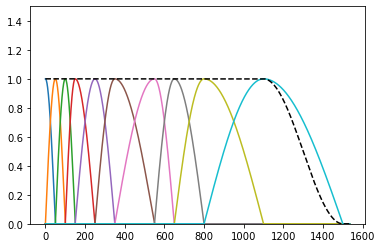

In [338]:
for i in nilcWin:
    plt.plot(i)
plt.plot(np.sum(nilcWin**2, axis=0), c='k', ls='--')
plt.ylim(0, 1.5)

/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(0.0, 10.0)

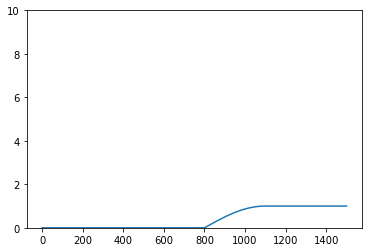

In [226]:
plt.plot(nilcWin[9] / np.sum(nilcWin**2, axis=0)**0.5)
plt.ylim(0, 10)

In [164]:
# basic constant definition and nilc window calculation
NSIDE = 512
LMAX = NSIDE * 3 - 1
J = 11
ell = np.arange(LMAX + 1)
nilcWin = np.array([b_lj(ell, j) for j in range(J)])
tmpSum = np.sum(nilcWin, axis=0)
nilcWinNorm = np.where(tmpSum==0, 1, tmpSum)
nilcWin = (nilcWin / nilcWinNorm) ** 0.5

In [165]:
# calculate LGL and HGL masks
pixInds = np.arange(hp.nside2npix(NSIDE))
pixAngs = hp.pix2ang(NSIDE, pixInds, lonlat=True)
LGLMask = (np.abs(pixAngs[1]) < 15).astype(float) + np.where((np.abs(pixAngs[1]) < 30) * (np.abs(pixAngs[1]) >= 15), 
                                                             np.cos((np.abs(pixAngs[1]) - 15) / 30 * np.pi)**2, 0)
HGLMask = np.ones(hp.nside2npix(NSIDE)) - LGLMask

In [387]:
detectors = ['K', 'Ka', 'Q', 'V', 'W']
detectorCount = [1, 1, 2, 2, 4]
fwhm = [0.93, 0.68, 0.53, 0.35, 0.23]
wmapDirectory = 'wmap_data/'
wmapBeamDirectory = 'wmap_beam/'
beamPath = wmapBeamDirectory + 'wmap_ampl_bl_{}{}_9yr_v5p1.txt'
# planckDirectory = ''
wmapMaps = []
alms = []
maskedAlms = []
OUTPUT_RES = 0.23 # degree
I_OUTPUT_RES = 0.23
QU_OUTPUT_RES = 0.35

OUT_RES_LS = [0.23, 0.35, 0.35]
INPAINT_RAD = 1 # degree
sLs = [0,2,2]
# ptsrc = read_wmap_ptsrc_catalog('wmap_data/wmap_ptsrc_catalog_9yr_v5p1.txt').T
# ptsrcInd = hp.ang2pix(NSIDE, ptsrc[0], ptsrc[1], lonlat=True)
fwhm = OUTPUT_RES * np.pi / 180

for i in range(5):
    det = detectors[i]
    tmpMap = hp.read_map(wmapDirectory+f"wmap_band_iqumap_r9_9yr_{det}_v5.fits", field=[0, 1, 2])
    tmpMap = hp.ud_grade(tmpMap, nside_out=NSIDE)
    tmpAlm = hp.map2alm(tmpMap)
    
    # get the beam window functions, average if multiple detectors associates to a same detector.
#     beamW = np.array(pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}{}_9yr_v5p1.txt".format(det, 1), 
#                      comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[:, 1])
#     if detectorCount[i] > 1:
#         for ct in range(2, detectorCount[i] + 1):
#             beamW += np.array(pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}{}_9yr_v5p1.txt".format(det, ct), 
#                               comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[:, 1])
#     beamW = beamW / detectorCount[i]

    beamW = get_detector_beam(beamPath, det, detectorCount[i])
    
#     deconvolveBeam = 1 / beamW
#     ell = np.arange(LMAX + 1)
    
#     if len(deconvolveBeam) < LMAX + 1:
#         deconvolveBeam = np.append(deconvolveBeam, np.zeros(LMAX + 1 - len(deconvolveBeam)))
#     else:
#         deconvolveBeam = deconvolveBeam[:LMAX+1]
#     tmpLs = []
#     for i in range(3):
#         s = sLs[i]
#         gfwhm = OUT_RES_LS[i] * np.pi / 180
#         gaussian = np.exp(-0.5 * (ell * (ell + 1) - s ** 2) * gfwhm ** 2)
#         deconvolvedAlm = np.array([hp.almxfl(tpalm, gaussian) for tpalm in tmpAlm])
    
    
#     smoothTmpAlm = hp.smoothalm(deconvolvedAlm, fwhm=fwhm)
#     tmpMaps = hp.alm2map(smoothTmpAlm, NSIDE)
#     beamTransfer = pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}1_9yr_v5p1.txt".format(det), 
#                                  comment='#', header=None, usecols=[0,1,2], delim_whitespace=True)
#     beamWin = np.array(beamTransfer.loc[:, 1])**2
#     if len(beamWin) < LMAX + 1:
#         beamWin = np.append(beamWin, np.ones(LMAX + 1 - len(beamWin)))
#     else:
#         beamWin = beamWin[:LMAX + 1]
#     almBeamWin = nilcWin2almWin([beamWin], lmax=LMAX)
#     smoothTmpMap = smooth(tmpMap, input_res=fwhm[detectors.index(det)]*60,
#                           output_res_i=OUTPUT_RES*60,
#                           output_res_qu=OUTPUT_RES*60)
#     inpaintTmpMap = []
#     for m in smoothTmpMap:
#         for ind in ptsrcInd:
#             m = inpaint_pointsources(m, ind, radius=INPAINT_RAD)
#         inpaintTmpMap.append(m)
#     inpaintTmpMap = np.array(inpaintTmpMap)
#     wmapMaps.append(inpaintTmpMap)
#     wmapMaps.append(smoothTmpMap * LGLMask)
    tmpMaps = gaussian_smoothing(tmpMap, beamW, I_OUTPUT_RES, QU_OUTPUT_RES, NSIDE)
    alms.append(hp.map2alm(tmpMaps))
#     maskedAlms.append(hp.map2alm(tmpMaps * HGLMask))
    
#     CLs.append(hp.anafast(smoothTmpMap))
# almLMAX = hp.Alm.getlmax(len(alms[0][0]))

# calculate alm window
# almWins = nilcWin2almWin(nilcWin, almLMAX)

# compute needlet coefficent
# dimention {j, freqChannels, Components, NPix}
# LGL
# needletAlms = []
needletCoef = [] 

for idx, fl in enumerate(nilcWin):
    tmpWghtAlms = []
    tmpWghtMaps = []
    for freqAlm in alms:
        # alm at each frequency grouped as I, Q, U
        wghtFreqAlms = np.array([hp.almxfl(indivAlm, fl) for indivAlm in freqAlm])
        wghtFreqMaps = hp.alm2map(wghtFreqAlms, nside=windowDefInfo[idx][3])
#         tmpWghtAlms.append(wghtFreqAlms)
        tmpWghtMaps.append(wghtFreqMaps)
#     needletAlms.append(np.array(tmpWghtAlms))
    needletCoef.append(np.array(tmpWghtMaps))
# needletAlms = needletAlms
# needletCoef = needletCoef

# HGL
# m_needletAlms = []
# m_needletCoef = []
# for idx, fl in enumerate(nilcWin):
#     tmpWghtAlms = []
#     tmpWghtMaps = []
#     for freqAlm in maskedAlms:
#         # alm at each frequency grouped as I, Q, U
#         wghtFreqAlms = np.array([hp.almxfl(indivAlm, fl) for indivAlm in freqAlm])
#         wghtFreqMaps = hp.alm2map(wghtFreqAlms, nside=windowDefInfo[idx][3])
#         tmpWghtAlms.append(wghtFreqAlms)
#         tmpWghtMaps.append(wghtFreqMaps)
#     m_needletAlms.append(np.array(tmpWghtAlms))
#     m_needletCoef.append(np.array(tmpWghtMaps))
# m_needletAlms = m_needletAlms
# m_needletCoef = m_needletCoef

In [388]:
# ILC implementation without considering the 32x32 localization
# a = np.atleast_2d(np.ones(5)).T # this is for CMB only
# nilcCoef = []
# for groupj in needletCoef:
#     # rearrange to separate components
#     tGroupJ = np.transpose(groupj, axes=(1, 0, 2))
#     compGroupJ = []
#     for idcomp, comp in enumerate(tGroupJ):
#         tComp = comp.T
#         a = np.atleast_2d(np.ones(5)).T
#         if idcomp != 0:
#             tComp = tComp[:, :4]
#             comp = comp[:4]
#             a = np.atleast_2d(np.ones(4)).T
#         Rs = np.array([np.atleast_2d(gamma).T @ np.atleast_2d(gamma) for gamma in tComp])
#         RBar = np.mean(Rs, axis=0)
#         ilcWght = (a.T @ np.linalg.pinv(RBar, rcond=1e-15)) / (a.T @ np.linalg.pinv(RBar, rcond=1e-15) @ a)
#         ilcWght = np.where(np.isnan(ilcWght), 0, ilcWght)
#         print(ilcWght)
#         compGroupJ.append((ilcWght @ comp)[0])
#     nilcCoef.append(np.array(compGroupJ))
# nilcCoef = np.array(nilcCoef)

nilcCoef = []
wtLs = []
for groupj in needletCoef:
    # rearrange to separate components
    tGroupJ = np.transpose(groupj, axes=(1, 0, 2))
    compGroupJ = []
    for idx, comp in enumerate(tGroupJ):
        if idx == 0: 
            needletCMB, wt = ilc(comp)
        else:
            needletCMB, wt = ilc(comp[:4])
        compGroupJ.append(needletCMB)
        wtLs.append(wt)
        print(wt)
    nilcCoef.append(np.array(compGroupJ))

# print("END OF MASK REGION 1")
# m_nilcCoef = []
# for groupj in m_needletCoef:
#     # rearrange to separate components
#     tGroupJ = np.transpose(groupj, axes=(1, 0, 2))
#     compGroupJ = []
#     for idcomp, comp in enumerate(tGroupJ):
#         tComp = comp.T
#         a = np.atleast_2d(np.ones(5)).T
#         if idcomp != 0:
#             tComp = tComp[:, :4]
#             comp = comp[:4]
#             a = np.atleast_2d(np.ones(4)).T
#         Rs = np.array([np.atleast_2d(gamma).T @ np.atleast_2d(gamma) for gamma in tComp])
#         RBar = np.sum(Rs * np.transpose(np.array([[HGLMask]]), axes=[2,0,1]), axis=0) / np.sum(HGLMask)
#         ilcWght = (a.T @ np.linalg.pinv(RBar, rcond=1e-15)) / (a.T @ np.linalg.pinv(RBar, rcond=1e-15) @ a)
#         ilcWght = np.where(np.isnan(ilcWght), 0, ilcWght)
#         print(ilcWght)
#         compGroupJ.append((ilcWght @ comp)[0])
#     m_nilcCoef.append(np.array(compGroupJ))
# # m_nilcCoef = np.array(m_nilcCoef)

[ 0.23742463 -0.31784011 -1.82820351  4.19770458 -1.28908559]
[-0.23827664  0.38894058  0.51403311  0.33530296]
[-0.20661808  0.3769698   0.39642006  0.43322822]
[-0.12225839  0.63285687 -1.45607732  1.97168644 -0.0262076 ]
[-0.19435696  0.25092607  0.43807747  0.50535342]
[-0.17718882  0.3180435   0.44060141  0.41854392]
[-1.14648659e-02  1.83482789e-02 -7.80206242e-01  1.77310322e+00
  2.19606693e-04]
[-0.21334318  0.23207612  0.4661805   0.51508655]
[-0.06838441  0.27607446  0.41333605  0.3789739 ]
[ 0.04228521 -0.37905641 -0.24622647  1.53535278  0.0476449 ]
[-0.16629436  0.16448094  0.43961125  0.56220218]
[0.01504544 0.23334787 0.38437065 0.36723604]
[ 0.04526122 -0.40430594 -0.17463424  1.37877736  0.15490161]
[-0.07607858  0.10794967  0.37015888  0.59797002]
[0.04329801 0.19517788 0.3593411  0.402183  ]
[-0.00410755 -0.17096887 -0.24254594  0.93112762  0.48649474]
[-0.00478689  0.07740777  0.30514125  0.62223787]
[0.01774807 0.12049922 0.33698179 0.52477091]
[-0.00258202 -0.112

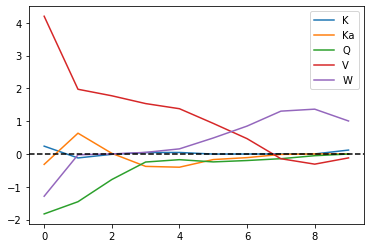

In [398]:
compIdx = {'I': 0, 'Q':1, 'U':2}

tmp = np.array([wtLs[i * 3 + compIdx['I']] for i in range(10)]).T
for idx, wts in enumerate(tmp):
    plt.plot(wts, label=detectors[idx])
plt.legend()
plt.axhline(c='k', ls='--')

In [389]:
# convert back to maps
nilcAlmLs = [hp.map2alm(tmp) for tmp in nilcCoef]
nilcAlmLs = [hp.map2alm(hp.alm2map(tmp, nside=NSIDE)) for tmp in nilcAlmLs]


nilcAlms = np.zeros(shape=(3, len(nilcAlmLs[0][-1]))).astype('complex128')
# m_nilcAlms = np.zeros(shape=(3, len(nilcAlmLs[0, 0]))).astype('complex128')

for j in range(10):
    nilcAlms += np.array([hp.almxfl(tAlm, nilcWin[j]) for tAlm in nilcAlmLs[j]])
#     m_nilcAlms += np.array([hp.almxfl(tAlm, nilcWin[j]) for tAlm in m_nilcAlmLs[j]])
nilcCMB = hp.alm2map(nilcAlms, nside=NSIDE)# + hp.alm2map(m_nilcAlms, nside=NSIDE)

Smoothing map...
Smoothing I to 13.8 arcmin...


Smoothing Q, U to 150 arcmin...


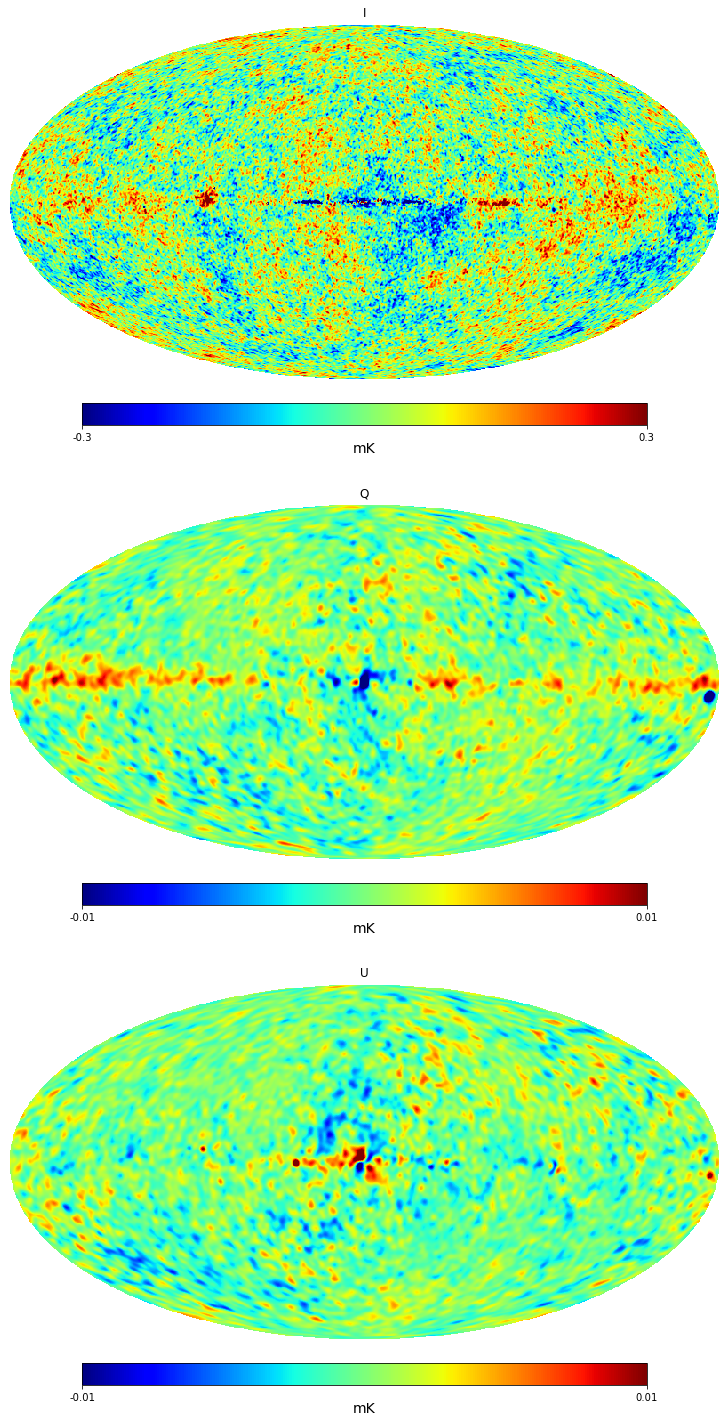

In [395]:
plt.figure(figsize=(16,20))
compName = ['I', 'Q', 'U']
val = [0.3, 0.01, 0.01]
smoothedNilcCMB = smooth(nilcCMB, OUTPUT_RES * 60, OUTPUT_RES * 60, 150)
for i in range(3):
    hp.mollview(smoothedNilcCMB[i], title=compName[i], min=-val[i], max=val[i], sub=(3,1,i + 1), unit='mK', cmap='jet')

/home/andrewliu/.local/lib/python3.7/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/home/andrewliu/.local/lib/python3.7/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


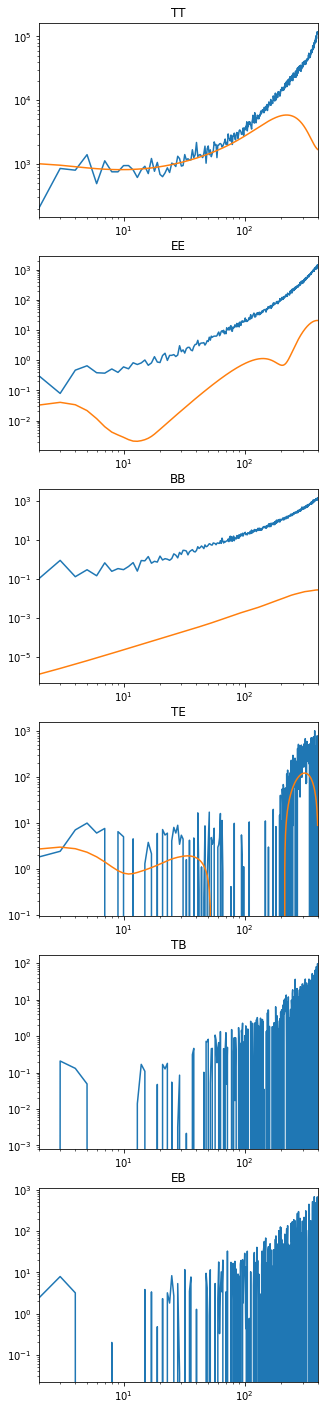

In [396]:
# cutDegree = 1
CLs = hp.anafast(nilcCMB, gal_cut=cutDegree)# / (np.sum(pixAngs[1] > cutDegree) / hp.nside2npix(NSIDE))
polarization = ['TT', 'EE', 'BB', 'TE', 'TB', 'EB']
plotLMAX = 400
ell = np.arange(2, plotLMAX+1)
cambCLs = get_spectra(lmax=plotLMAX)
# cambCLs = cambCLs[[0, 3, 1, 2]]
# beamW = np.array(pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}1_9yr_v5p1.txt".format('K'), 
#                              comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[2:plotLMAX, 1])**2
# + np.array(pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}1_9yr_v5p1.txt".format('Ka'), 
#                              comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[2:plotLMAX, 1])**2
# + np.array(pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}1_9yr_v5p1.txt".format('Q'), 
#                              comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[2:plotLMAX, 1])**2
# + np.array(pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}1_9yr_v5p1.txt".format('V'), 
#                              comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[2:plotLMAX, 1])**2
# + np.array(pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}1_9yr_v5p1.txt".format('W'), 
#                              comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[2:plotLMAX, 1])**2

fig, ax = plt.subplots(6, 1)
fig.set_figheight(25)
fig.set_figwidth(5)
for i in range(6):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    
    ax[i].set_xlim(2, plotLMAX + 1)
    ax[i].set_title(polarization[i]) 
    ax[i].plot(ell, CLs[i][2:plotLMAX + 1] * ell * (ell + 1) / (2 * np.pi) * 1e6 / gaussian[2:plotLMAX + 1]**2)
    if i < 4:
        ax[i].plot(ell, cambCLs[i][2:] * ell * (ell + 1) / (2 * np.pi))
    else:
        ax[i].axhline(xmax=plotLMAX, c='k', ls='--')

In [157]:
hp.Alm.getidx(767, 767, 1)

1534

In [155]:
(768 + 1) * 768 / 2

295296.0

In [221]:
iComp

array([[-5.76820213e-04, -3.68371022e-04, -7.29980120e-04, ...,
         2.68467172e-05,  4.77999558e-04,  8.59620114e-04],
       [-5.40609776e-04, -7.68418938e-04, -7.34366892e-04, ...,
         2.68472013e-04,  3.83988934e-04,  4.66757662e-04],
       [-6.55321285e-04, -8.72208780e-04, -7.36815903e-04, ...,
         1.83260092e-04,  3.03559757e-04,  3.20682884e-04],
       [-2.98404350e-04, -5.40389279e-04, -5.34084712e-04, ...,
         3.59272658e-04,  4.87813266e-04,  5.51920929e-04],
       [-6.65572899e-04, -7.96169824e-04, -7.04929068e-04, ...,
         1.99772134e-04,  2.38172204e-04,  2.61880668e-04]])

In [209]:
np.transpose(groupj, axes=(1,0,2))

array([[[-5.76820213e-04, -3.68371022e-04, -7.29980120e-04, ...,
          2.68467172e-05,  4.77999558e-04,  8.59620114e-04],
        [-5.40609776e-04, -7.68418938e-04, -7.34366892e-04, ...,
          2.68472013e-04,  3.83988934e-04,  4.66757662e-04],
        [-6.55321285e-04, -8.72208780e-04, -7.36815903e-04, ...,
          1.83260092e-04,  3.03559757e-04,  3.20682884e-04],
        [-2.98404350e-04, -5.40389279e-04, -5.34084712e-04, ...,
          3.59272658e-04,  4.87813266e-04,  5.51920929e-04],
        [-6.65572899e-04, -7.96169824e-04, -7.04929068e-04, ...,
          1.99772134e-04,  2.38172204e-04,  2.61880668e-04]],

       [[ 4.50982943e-04,  3.39092484e-04,  6.08831800e-04, ...,
          2.71729059e-04,  9.60951674e-04,  6.41417838e-05],
        [-4.99699874e-04, -4.61589961e-04, -3.80653264e-04, ...,
         -2.45159365e-04,  3.12115357e-04,  1.81164951e-04],
        [ 3.87489629e-04,  3.08185849e-04,  2.37472117e-04, ...,
          7.35690898e-05,  3.32142737e-04, -2.13123

In [174]:
almWins = nilcWin2almWin(nilcWin, almLMAX)

In [172]:
np.shape(almWins)

(20, 295296)

In [231]:
np.array([0])/np.array([0])

/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


array([nan])

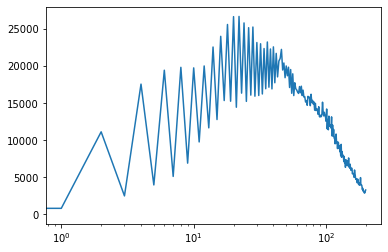

In [359]:
plt.xscale('log')
plt.plot(hp.anafast(wmapMaps[4])[0, :200] * ell * (ell + 1) / (2 * np.pi) * 1e6)

/etc/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  return newcm
/etc/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  
/etc/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you c

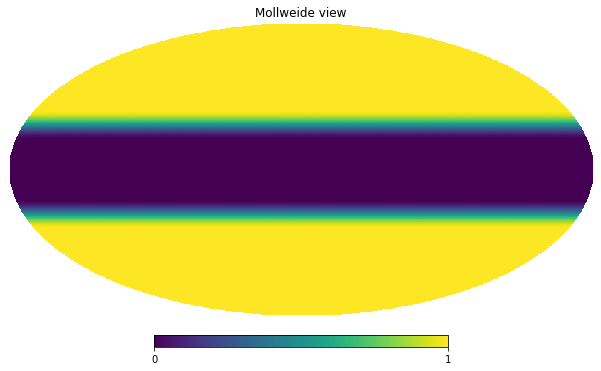

In [335]:
hp.mollview(HGLMask)

<function numpy.prod(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>

In [318]:

np.shape(np.transpose(np.array([[LGLMask]]), axes=[2,0,1]))

(3145728, 1, 1)

In [400]:
nilcCMB[0]

array([-0.11188833, -0.11189207, -0.09948688, ..., -0.02546451,
       -0.02144376, -0.01638583])

In [402]:
cambCLs

array([[0.00000000e+00, 0.00000000e+00, 1.05882020e+03, 5.02170402e+02,
        2.85506510e+02, 1.82518221e+02, 1.26600149e+02, 9.31847558e+01,
        7.16776847e+01, 5.70670125e+01, 4.66828594e+01, 3.90087419e+01,
        3.32264391e+01, 2.87120876e+01, 2.51190962e+01, 2.21870290e+01,
        1.98036319e+01, 1.78407320e+01, 1.61864373e+01, 1.47915704e+01,
        1.35814273e+01, 1.25333423e+01, 1.16198684e+01, 1.08143532e+01,
        1.01033517e+01, 9.47378045e+00, 8.90923305e+00, 8.40416106e+00,
        7.94910725e+00, 7.53698447e+00, 7.16374046e+00, 6.82073963e+00,
        6.50939649e+00, 6.22302169e+00, 5.95881395e+00, 5.71732661e+00,
        5.49180145e+00, 5.28310386e+00, 5.09001738e+00, 4.91059917e+00,
        4.74323467e+00, 4.58650465e+00, 4.43949696e+00, 4.30143171e+00,
        4.17172656e+00, 4.04989363e+00, 3.93519493e+00, 3.82701245e+00,
        3.72476721e+00, 3.62797898e+00, 3.53637955e+00],
       [0.00000000e+00, 0.00000000e+00, 2.03546060e-05, 2.03056740e-05,
       

In [466]:
wmapBeamDirectory = 'wmap_beam/'
beamTransfer = pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}_9yr_v5p1.txt".format('K1'), 
                             comment='#', header=None, usecols=[0,1,2], delim_whitespace=True)

In [467]:
beamTransfer.loc[:, 1]

0      1.000082
1      1.000000
2      0.999837
3      0.999593
4      0.999269
         ...   
746    0.000054
747    0.000053
748    0.000052
749    0.000050
750    0.000049
Name: 1, Length: 751, dtype: float64

In [524]:
np.array(hp.almxfl(tAlm, nilcWin[j]) for tAlm in nilcAlmLs[j])

array(<generator object <genexpr> at 0x7f96336c7250>, dtype=object)

In [22]:
m_needletCoef

array([[[[-7.93021101e-04,  6.70053712e-04,  2.38922961e-04, ...,
          -1.76256792e-04,  8.27840031e-04,  8.38459946e-04],
         [ 6.20971470e-04,  5.61603329e-04,  3.45440121e-04, ...,
           1.00977074e-03,  5.78548545e-04,  6.34662405e-05],
         [ 4.03436428e-04, -6.97931027e-04,  1.48843704e-04, ...,
           1.06914933e-03,  1.27159273e-03,  1.34216351e-04]],

        [[-2.50349118e-04, -3.71426088e-04, -3.73442005e-04, ...,
           1.78525393e-04,  2.54296877e-04,  2.84456324e-04],
         [-3.00592607e-04, -2.89895853e-04, -2.39335333e-04, ...,
          -1.69417192e-04,  1.66839710e-04,  1.06822922e-04],
         [ 1.35939929e-05,  1.51245040e-04,  5.39016302e-04, ...,
           2.05375775e-05, -1.34138917e-04, -1.03788461e-04]],

        [[-3.18546641e-04, -4.39554112e-04, -3.65963742e-04, ...,
           1.10382744e-04,  2.00622691e-04,  2.04714540e-04],
         [ 2.15030327e-04,  1.74712365e-04,  1.27662813e-04, ...,
           1.72682730e-05,  1.7696

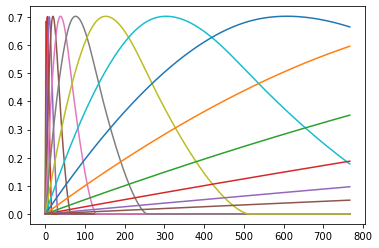

In [26]:
for i in range(J):
    plt.plot(nilcWin[i])

In [96]:
for tp in tmpWghtAlms:
    print(np.shape(tp))

(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 1180416)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)
(3, 295296)


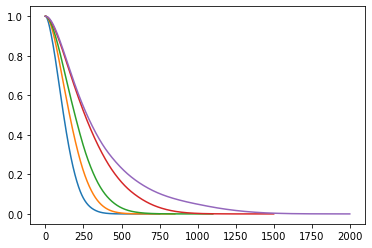

In [71]:
for i in range(5):
    det = detectors[i]
    beamW = np.array(pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}1_9yr_v5p1.txt".format(det), 
                     comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[:, 1])**2
    if detectorCount[i] > 1:
        for ct in range(2, detectorCount[i] + 1):
            beamW += np.array(pd.read_table(wmapBeamDirectory + "wmap_ampl_bl_{}{}_9yr_v5p1.txt".format(det, ct), 
                              comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[:, 1])**2
    beamW = beamW / detectorCount[i]
    
    plt.plot(beamW)

In [100]:
for i in enumerate(['a', 'b']):
    print(i)

(0, 'a')
(1, 'b')


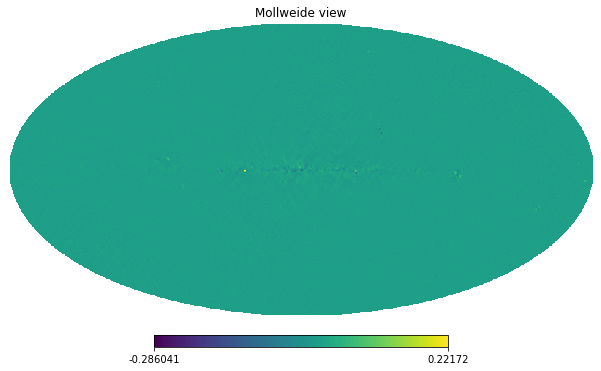

In [105]:
hp.mollview(tComp.T[0])

In [109]:
comp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [194]:
float(True)

1.0

In [355]:
np.ones(shape=(5,3,3)) * np.transpose(np.array([[np.arange(5)]]), axes=(2,0,1))

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]],

       [[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]]])